In [1]:
import pandas as pd

import numpy as np

#this is the sales data in an xlsx file
df = pd.read_excel("Commandes 2020-03-29_2022-03-21.xlsx")

#first we have to remove all employee orders, we can drop rows with employee emails (these were provided to me).
#NOTE!!! To preserve employee privacy, I have left out several lines in this version, one for each employee.
df.drop(index=df[df['E-mail'] == 'john.smith@example.com'].index, inplace=True) #This is an example!


#the data is 'backwards' (it goes newest to oldest) so let's flip it now
df = df.reindex(index=df.index[::-1])

#reset the index
df = df.reset_index()


#further data cleaning. We want to hide emails for confidentiality as well as have a convenient way of ordering them. Each one
#becomes a numerical ID.
df['E-mail'] = pd.factorize(df['E-mail'])[0]

#we drop some columns we won't use as well as the extra backwards (old) index
df = df.drop(columns=['Point de collecte', 'ID point de collecte', 'index', 'Adresse (Livraison)', 'Code postal (Livraison)',
                     'Ville (Livraison)'])

In [2]:
df #here's the anonymized data frame just for reference/interest! 

,Date commandé,No de commande,E-mail,Total payé,SKU,Nom du produit,Categorie,Quantité,Prix du produit,Code de coupon,Réduction
0,2020-03-29 16:44:04,664,0,43.84,PQ0211,Grand Panier,"Panier,Panier principal",1.0,40.00,NaN,NaN
1,2020-03-30 10:23:53,665,1,34.12,False,NaN,NaN,1.0,30.00,NaN,NaN
2,2020-03-30 10:55:52,666,2,34.12,False,NaN,NaN,1.0,30.00,NaN,NaN
3,2020-03-30 11:19:59,667,3,49.84,pourboire-01,Pourboire,Non classé,1.0,6.00,NaN,NaN
4,2020-03-30 11:19:59,667,3,49.84,PQ0211,Grand Panier,"Panier,Panier principal",1.0,40.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
338278,2022-03-21 22:28:27,51727,3915,190.75,PQ0552,Zucchinis,"Produit unité,Légumes,Zucchinis, piments et au...",1.0,6.95,NaN,NaN
338279,2022-03-21 22:28:27,51727,3915,190.75,PQ0344,Fèves vertes,"Produit unité,Légumes,Fèves, poireaux et artic...",1.0,3.95,NaN,NaN
338280,2022-03-21 22:28:27,51727,3915,190.75,PQ0555,Concombre anglais,"Produit unité,Légumes,Tomates, concombres et a...",1.0,2.75,NaN,NaN
338281,2022-03-21 22:28:27,51727,3915,190.75,PQ0499,Tomates classique,"Produit unité,Légumes,Tomates, concombres et a...",1.0,4.50,NaN,NaN


In [3]:
#Here we will work on the coupon part of the analysis

#creating a copy specifically for the coupon questions

df2 = df.copy()

df2['coupons'] = df2['Code de coupon']

#removing bienvenue10 because it was not used a lot during the fall.
#df2['coupons'] = ['bienvenue10' if x == 'bienvenue10' else 'bienvenue20' if x == 'bienvenue20'
                  #else 'soleil10' if x == 'soleil10' else 0 for x in df2['coupons']]
    
#we created a new column that is just for the two coupon codes that we will analyze.
df2['coupons'] = ['bienvenue20' if x == 'bienvenue20'
                  else 'soleil10' if x == 'soleil10' else 0 for x in df2['coupons']]

#we are going to dummy encode our two coupons.  
coupons = pd.get_dummies(df2['coupons'])
#Here we don't do n-1 categories because no coupon is a category.

#we join the coupons back into our dataframe.
df2 = df2.join(coupons)

#for the coupons, I was intructed by my contact at panier quebecois to only analyze after soleil10 was introduced, which 
#took place on July 1st 2021. We also have to be mindful of the business question being asked which is what impact first-order
#promo codes have on customer behaviour, which means we are in large part interested in what happens AFTER the first order.

#For these reasons, I am interested in all the orders up to PRESENT of customers who made their FIRST order BETWEEN July 1st 
#2021 and December 31st 2021. Here is how we do this:

#use drop_duplictes to grab the first time we see any customer email (i.e. their first order)
oneemail = df2.drop_duplicates(subset=['E-mail'])

#I create conditions for emails we don't want, which are those that first appear either before or after our desired interval
earlymask = oneemail['Date commandé'] < '2021-06-30 00:00:00' 
latemask = oneemail['Date commandé'] > '2022-01-01 00:00:00'

#we use these conditions to create  list of emails tht only occur before and after our interval
before = oneemail.loc[earlymask, 'E-mail'].tolist()
before = set(before)

after = oneemail.loc[latemask, 'E-mail'].tolist()
after = set(after)

#these are the orders UP TO PRESENT of people who made their first order between June 30th and Jan 1st 2021-22 
df2 = df2[~df2['E-mail'].isin(before) & ~df2['E-mail'].isin(after)]
df2

,Date commandé,No de commande,E-mail,Total payé,SKU,Nom du produit,Categorie,Quantité,Prix du produit,Code de coupon,Réduction,coupons,0,bienvenue20,soleil10
194538,2021-06-30 03:24:35,31777,3192,165.88,PQ0884,Granola vrac 'Nature',"Produit unité,Vrac,Céréales",1.0,4.99,NaN,NaN,0,1,0,0
194539,2021-06-30 03:24:35,31777,3192,165.88,PQ1053,Miel de Trèfle liquide,"Produit unité,Épiceries,Miel, confiture et tar...",1.0,7.75,NaN,NaN,0,1,0,0
194540,2021-06-30 03:24:35,31777,3192,165.88,PQ1360,Gressins 'au blé entier',"Produit unité,Épiceries,Collations",1.0,1.99,NaN,NaN,0,1,0,0
194541,2021-06-30 03:24:35,31777,3192,165.88,PQ0515,Oeufs bruns,"Produit unité,Épiceries,Oeufs",1.0,5.95,NaN,NaN,0,1,0,0
194542,2021-06-30 03:24:35,31777,3192,165.88,PQ0829,Croissants,"Produit unité,Boulangerie,Viennoiserie",1.0,8.90,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338278,2022-03-21 22:28:27,51727,3915,190.75,PQ0552,Zucchinis,"Produit unité,Légumes,Zucchinis, piments et au...",1.0,6.95,NaN,NaN,0,1,0,0
338279,2022-03-21 22:28:27,51727,3915,190.75,PQ0344,Fèves vertes,"Produit unité,Légumes,Fèves, poireaux et artic...",1.0,3.95,NaN,NaN,0,1,0,0
338280,2022-03-21 22:28:27,51727,3915,190.75,PQ0555,Concombre anglais,"Produit unité,Légumes,Tomates, concombres et a...",1.0,2.75,NaN,NaN,0,1,0,0
338281,2022-03-21 22:28:27,51727,3915,190.75,PQ0499,Tomates classique,"Produit unité,Légumes,Tomates, concombres et a...",1.0,4.50,NaN,NaN,0,1,0,0


<AxesSubplot:>

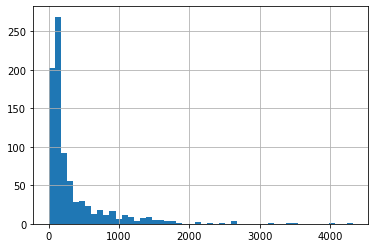

In [4]:
#Let's answer the question of whether customers who use one of these coupons are higher value:

#We need to extract the price of each order, which is included on each line of the order in the dataframe so we will drop
#duplicates
totalpercustomer = df2.drop_duplicates(subset=['No de commande'], keep='last')  #coupons are on the last line of the inverted df
totalpercustomer = totalpercustomer.groupby(['E-mail']).sum() #we're just wanting the total paid for all orders per customer,
                                                            #this will be fine for our coupons as they only occur once per customer
    
totalpercustomer['Total payé'].hist(bins=50)
#this is quite right-skewed, as we would generally expect with pricing data. Interestingly, the log transformed data below is
#not as right skewed. Because interpretability is paramount for answering business questions,I'm going to stick with the raw 
#data. 
#Going forward, I will tend to prioritize interpretability unless there are extremely compelling reasons to not do so.



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

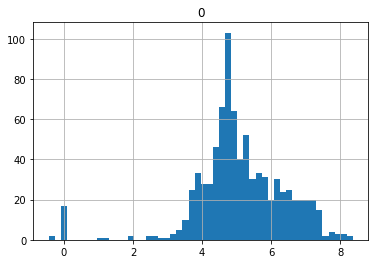

In [5]:
#log data just for interest. 
log = (totalpercustomer['Total payé'])
log2 = [np.log(x) if x >0 else 0 for x in log]
log2 = pd.DataFrame(log2)
log2.hist(bins=50)

In [6]:
#here are some descriptive stats!

#isolating by promo code
bienvenue20 = totalpercustomer.loc[(totalpercustomer['bienvenue20'] == 1)]

#getting the mean order value by promo code
bienvenue20_mean = bienvenue20['Total payé'].mean()
print(bienvenue20_mean)

#repeat X3
soleil10 = totalpercustomer.loc[(totalpercustomer['soleil10'] == 1)]
soleil10_mean = soleil10['Total payé'].mean()
print(soleil10_mean)
no_promo = totalpercustomer.loc[(totalpercustomer['soleil10'] == 0) & (totalpercustomer['bienvenue20'] == 0)]
no_promo_mean = no_promo['Total payé'].mean()
print(no_promo_mean)


import scipy.stats as stats
#Testing significance levels is a biiiit trickier as we can do it multiple ways. 
#The stats.f_oneway should be comperable to an ANOVA/
F, p = stats.f_oneway(soleil10['Total payé'], bienvenue20['Total payé'], no_promo['Total payé'])
print(p)

#that being said, we really just  whether each promo code is different from the mean:
bien_vs_no = stats.ttest_ind(bienvenue20['Total payé'], no_promo['Total payé'], equal_var=False)
print(bien_vs_no)
sol_vs_no = stats.ttest_ind(soleil10['Total payé'], no_promo['Total payé'], equal_var=False)
print(sol_vs_no)


#bienvenue10 has the highest total order value which makes sense as they have to order >$100 on first order
#soleil10  is higher than no promo code, but there is a 74% chance this difference is due to chance! We can see that only 17
#customers used the soleil10 promo code so ideally we would need more data
print(totalpercustomer['soleil10'].value_counts())
print(totalpercustomer['bienvenue20'].value_counts())

394.42982758620695
365.15882352941173
336.12472990777354
0.6689093278736999
Ttest_indResult(statistic=0.9199838866332509, pvalue=0.36086437710497854)
Ttest_indResult(statistic=0.33276190439430514, pvalue=0.743279048202709)
0    817
1     17
Name: soleil10, dtype: int64
0    776
1     58
Name: bienvenue20, dtype: int64


In [7]:
import statsmodels.api as sm
from scipy import stats

#we do the same thing with the NegativeBinomial test and linear regression. Technically, negative binomial is a better fit for 
#the skewed data we have. However, we are choosing again to prioritize interpretability. 
X = totalpercustomer[['bienvenue20', 'soleil10']]
Y = totalpercustomer['Total payé']
X = sm.add_constant(X)

neg_bino_est = sm.NegativeBinomial(Y,X).fit()
print(neg_bino_est.summary())

regr = sm.OLS(Y, X).fit()

print(regr.summary())
#the tests have relatively similar results. The R-squared is absurdly low, we can say that these coupon codes are NOT a good 
#predictor of total orders. The coefficients of the linear regression match the descriptive statistics above, so we are going
#to report the p-values from the linear regression in our presentation. The values will be copied over into our Dash Notebook.

C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Optimization terminated successfully.
         Current function value: 6.813769
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
                     NegativeBinomial Regression Results                      
Dep. Variable:             Total payé   No. Observations:                  834
Model:               NegativeBinomial   Df Residuals:                      831
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 May 2022   Pseudo R-squ.:               0.0001065
Time:                        14:32:37   Log-Likelihood:                -5682.7
converged:                       True   LL-Null:                       -5683.3
Covariance Type:            nonrobust   LLR p-value:                    0.5460
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.8175      0.041    14

C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [8]:
#Next, likelihood of ordering again based on initial promo code.
#This will be the number of orders per customer for each coupon group.

#creating a new data frame for this question
orderspercustomer = df2.copy()

#again we just need one entry per order:
orderspercustomer = orderspercustomer.drop_duplicates(subset=['No de commande'])
#to count the orders we group by email
orderspercustomer = orderspercustomer.groupby(['E-mail']).count()
#we can use the same X columns as from the previous question.
orderspercustomer[['bienvenue20', 'soleil10']] = totalpercustomer[['bienvenue20', 'soleil10']]

#descriptive statistics, we again select by promo code status and calculate the mean
orderspercustomer_20 = orderspercustomer.loc[(orderspercustomer['bienvenue20'] == 1)]
orderspercustomer_20_mean = orderspercustomer_20['Total payé'].mean()
print(orderspercustomer_20_mean)

#repeat X3
orderspercustomer_10 = orderspercustomer.loc[(orderspercustomer['soleil10'] == 1)]
orderspercustomer_10_mean = orderspercustomer_10['Total payé'].mean()
print(orderspercustomer_10_mean)
orderspercustomer_nopromo = orderspercustomer.loc[(orderspercustomer['soleil10'] == 0) & (orderspercustomer['bienvenue20'] == 0)]
orderspercustomer_nopromo_mean = orderspercustomer_nopromo['Total payé'].mean()
print(orderspercustomer_nopromo_mean)

#same significance tests
import scipy.stats as stats
F, p = stats.f_oneway(orderspercustomer_10['Total payé'], orderspercustomer_20['Total payé'], orderspercustomer_nopromo['Total payé'])
print(p)

bien_vs_no = stats.ttest_ind(orderspercustomer_20['Total payé'], orderspercustomer_nopromo['Total payé'], equal_var=False)
print(bien_vs_no)
sol_vs_no = stats.ttest_ind(orderspercustomer_10['Total payé'], orderspercustomer_nopromo['Total payé'], equal_var=False)
print(sol_vs_no)


#Those who did not use promo codes ordered on average 2.8 times. Those who used bienvenue20 ordered 2.7 times, but there is a 
#80% chance of selecting a more extreme sample if there were no difference between the means (p = 0.8). The soleil10 promo code 
#group ordered 3.29 times, and there is a 50% chance of sampling a more extreme value under the null hypothesis. Thus although 
#we cannot reject the null hypothesis, I feel as if this is an interesting result.
print(orderspercustomer['soleil10'].value_counts())
print(orderspercustomer['bienvenue20'].value_counts())

2.706896551724138
3.2941176470588234
2.802371541501976
0.8036799918368003
Ttest_indResult(statistic=-0.2491988772294621, pvalue=0.8039377288319574)
Ttest_indResult(statistic=0.6819828880033876, pvalue=0.5044807154080138)
0    817
1     17
Name: soleil10, dtype: int64
0    776
1     58
Name: bienvenue20, dtype: int64


In [9]:
#Next, likelyhood of ordering again. Really this will be the number of orders for each coupon group.
#lin reg and negative binomial regression tell similar stories. Again, the R-squared is minute which is unfortunate.

orderspercustomer
orderspercustomerX = orderspercustomer[['bienvenue20', 'soleil10']]
orderspercustomerY = orderspercustomer['Total payé']
orderspercustomerX = sm.add_constant(orderspercustomerX)
count_negbin = sm.NegativeBinomial(orderspercustomerY,orderspercustomerX ).fit()
print(count_negbin.summary())

count_regr = sm.OLS(orderspercustomerY, orderspercustomerX ).fit()

print(count_regr.summary())

C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 2.141750
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
                     NegativeBinomial Regression Results                      
Dep. Variable:             Total payé   No. Observations:                  834
Model:               NegativeBinomial   Df Residuals:                      831
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 May 2022   Pseudo R-squ.:               0.0001733
Time:                        14:32:37   Log-Likelihood:                -1786.2
converged:                       True   LL-Null:                       -1786.5
Covariance Type:            nonrobust   LLR p-value:                    0.7338
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0305      0.034     3

<AxesSubplot:>

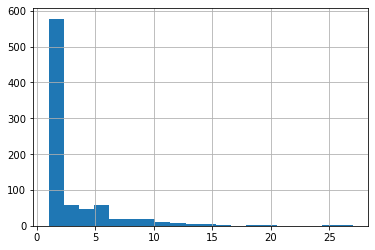

In [10]:
#I'll want to show some descriptive statistics too, particularly since the inferential statistics were inconclusive.
#histogram of orders per customer:
orderspercustomer['Total payé'].hist(bins = 20)

<AxesSubplot:>

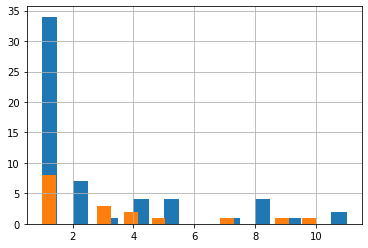

In [11]:
#Here we compare the two coupon codes, the districutions actually look fairly different
orderspercustomer['Total payé'].loc[(orderspercustomer['bienvenue20'] == 1)].hist(bins = 20)
orderspercustomer['Total payé'].loc[(orderspercustomer['soleil10'] == 1)].hist(bins = 20)


In [12]:
#To make the histograms I'll need the data in my other notebook:
orderspercustomer.to_csv('orderspercustomer.csv', index=False)

In [13]:
#I also want to calculate percentages who ordered again and who didn't order again by promo code.

#I'm creating a binary value for >1 order and just one order using list comprehension
repeat = orderspercustomer.copy()
repeat['Total payé'] = [0 if x == 1 else 1 for x in repeat['Total payé']]
repeat

#I am extracing the value counts for this new variable accross all three promo code categories
nopromo_repeat = repeat.loc[(repeat['soleil10'] == 0) & (repeat['bienvenue20'] == 0)]
print(nopromo_repeat['Total payé'].value_counts())

soleil10_repeat = repeat.loc[(repeat['soleil10'] == 1)]
print(soleil10_repeat['Total payé'].value_counts())

bienvenue20_repeat = repeat.loc[(repeat['bienvenue20'] == 1)]
print(bienvenue20_repeat['Total payé'].value_counts())

#Here we are just calculating percentages
nopromo_percent = 342 / (417 + 342)
print(nopromo_percent)

soleil10_percent = 8 / (8 + 9)
print(soleil10_percent)

bienvenue20_percent = 24 / (24 + 34)
print(bienvenue20_percent)

0    417
1    342
Name: Total payé, dtype: int64
1    9
0    8
Name: Total payé, dtype: int64
0    34
1    24
Name: Total payé, dtype: int64
0.4505928853754941
0.47058823529411764
0.41379310344827586


In [14]:
#Now we want to ask a different question, which is "Does using a coupon predict the subsequent value per order of a 
#customer?"
#This question only entails studying those who ordered more than once, so we will use our binary variable from
#the last question
ave_index = repeat.loc[(repeat['Total payé'] == 1)]
ave_index.index

#we use this index which contains the emails of those who ordered more than once to select from our original dataframe
ave = df2[df2['E-mail'].isin(ave_index.index)]

ave = ave.groupby(['E-mail', 'No de commande']).mean()
ave = ave.reset_index()
dont_keep = ave.drop_duplicates(subset=['E-mail'])

ave = ave[~ave['No de commande'].isin(dont_keep['No de commande'])]
ave = ave.groupby(['E-mail']).mean()
ave['average order'] = ave['Total payé']
#ave = ave.drop(columns = ['bienvenue20', 'soleil10'])
#ave = pd.merge(ave, codes[['bienvenue20', 'soleil10', 'E-mail']], on='E-mail', how='inner')
#ave = ave.drop_duplicates(subset=['No de commande'], keep='last')
codes_email = df2.loc[df2['No de commande'].isin(dont_keep['No de commande'])]
codes = codes_email.drop_duplicates(subset=['No de commande'], keep='last')
ave = pd.merge(ave, codes[['bienvenue20', 'soleil10', 'E-mail']], on='E-mail', how='inner')
ave['bienvenue20'] = ave['bienvenue20_y']
ave['soleil10'] = ave['soleil10_y']
averageX = ave[['soleil10', 'bienvenue20']]
averageX = sm.add_constant(averageX)
averageY = ave['average order']

neg_bino_est3 = sm.NegativeBinomial(averageY,averageX).fit()
print(neg_bino_est3.summary())

regr3 = sm.OLS(averageY, averageX).fit()

print(regr3.summary())

Optimization terminated successfully.
         Current function value: 5.544707
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
                     NegativeBinomial Regression Results                      
Dep. Variable:          average order   No. Observations:                  375
Model:               NegativeBinomial   Df Residuals:                      372
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 May 2022   Pseudo R-squ.:               0.0005693
Time:                        14:32:38   Log-Likelihood:                -2079.3
converged:                       True   LL-Null:                       -2080.4
Covariance Type:            nonrobust   LLR p-value:                    0.3059
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.7705      0.030    15

C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
